# XLK Next-Day Nowcast
Predict tomorrow's return of XLK (Technology ETF) using simple features:
 - Market controls: SPY, VIX
 - Momentum & volatility features on XLK
This is a learning project for Python + basic ML on time series.

In [1]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Executable: c:\Users\nadoy\OneDrive\Desktop\DS PROJECTS\stock-nowcast\.venv\Scripts\python.exe


In [2]:
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from joblib import dump

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


Download Prices (XLK target, SPY & VIX as features)

In [3]:
tickers = ["XLK", "SPY", "^VIX"] # Tech sector, market, volatility
px = yf.download(tickers, start="2015-01-01", auto_adjust=True, threads=False)["Close"].dropna()
px.columns = ["XLK", "SPY", "VIX"]
px.head

[*********************100%***********************]  3 of 3 completed


<bound method NDFrame.head of                   XLK        SPY       VIX
Date                                      
2015-01-02 171.568054  36.315060 17.790001
2015-01-05 168.469543  35.760700 19.920000
2015-01-06 166.882751  35.329525 21.120001
2015-01-07 168.962326  35.628708 19.309999
2015-01-08 171.960602  36.411854 17.010000
...               ...        ...       ...
2025-08-19 639.809998 261.619995 15.570000
2025-08-20 638.109985 259.850006 15.690000
2025-08-21 635.549988 258.910004 16.600000
2025-08-22 645.309998 262.420013 14.220000
2025-08-25 642.469971 261.829987 14.790000

[2677 rows x 3 columns]>

In [4]:
# Daily returns
ret = px.pct_change().dropna()
ret.columns = ["ret_xlk", "ret_spy", "ret_vix"]

# Feature table
feat = pd.DataFrame(index=ret.index)
feat["ret_xlk"] = ret["ret_xlk"]
feat["ret_spy"] = ret["ret_spy"]
feat["ret_vix"] = ret["ret_vix"]

# Momentum and volatility features on XLK
feat["mom_5"] = ret["ret_xlk"].rolling(5).mean()
feat["mom_10"] = ret["ret_xlk"].rolling(10).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat["vol_20"] = ret["ret_xlk"].rolling(20).std()

feat = feat.dropna()

# Shift featuers by 1 day so they're known before predicting next day
X = feat[["ret_spy", "ret_vix", "mom_5", "mom_10", "vol_10", "vol_20"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]

X.tail(), y.tail()

(             ret_spy   ret_vix     mom_5   mom_10   vol_10   vol_20
 Date                                                               
 2025-08-19  0.002145 -0.006627  0.002321 0.001918 0.005203 0.006751
 2025-08-20 -0.017463  0.038692 -0.000894 0.001882 0.005257 0.006908
 2025-08-21 -0.006765  0.007707 -0.002110 0.000850 0.005003 0.006708
 2025-08-22 -0.003617  0.057999 -0.002931 0.000533 0.005218 0.006778
 2025-08-25  0.013557 -0.143373  0.000609 0.001289 0.006719 0.007547,
 Date
 2025-08-19   -0.005425
 2025-08-20   -0.002657
 2025-08-21   -0.004012
 2025-08-22    0.015357
 2025-08-25   -0.004401
 Name: ret_xlk, dtype: float64)

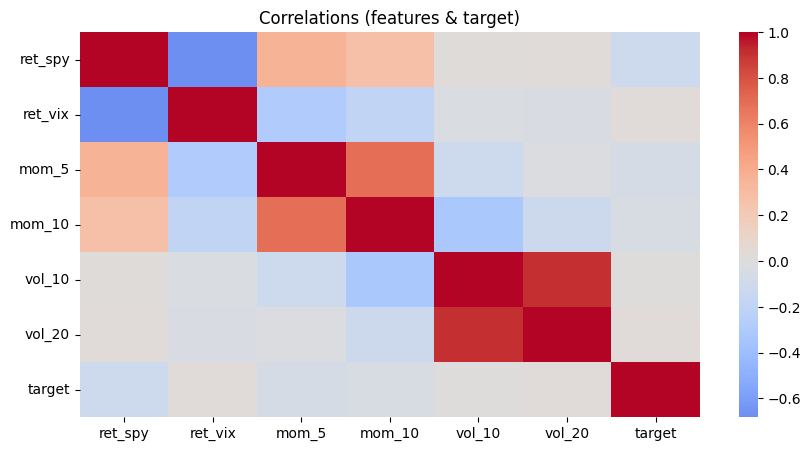

In [5]:
sns.heatmap(pd.concat([X, y.rename("target")], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlations (features & target)"); plt.show()


In [6]:
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
len(X_train), len(X_test)


(2124, 532)

In [7]:
def evaluate_preds(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # returns MSE
    rmse = np.sqrt(mse)                       # convert to RMSE manually
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}


baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

print("Baseline Zero:", evaluate_preds(y_test, baseline_zero))
print("Baseline Lag-1:", evaluate_preds(y_test, baseline_lag1))


Baseline Zero: {'MAE': 0.006673290476103093, 'RMSE': np.float64(0.010221059878134276), 'Directional_Accuracy': np.float64(0.0018796992481203006)}
Baseline Lag-1: {'MAE': 0.00982312834531054, 'RMSE': np.float64(0.014962264642883976), 'Directional_Accuracy': np.float64(0.5093984962406015)}


In [8]:
ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, max_iter=10000))])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

print("Ridge:", evaluate_preds(y_test, pred_ridge))
print("Lasso:", evaluate_preds(y_test, pred_lasso))


Ridge: {'MAE': 0.006714753572282711, 'RMSE': np.float64(0.010152038967833376), 'Directional_Accuracy': np.float64(0.5244360902255639)}
Lasso: {'MAE': 0.006660244227414895, 'RMSE': np.float64(0.010179604884514717), 'Directional_Accuracy': np.float64(0.5469924812030075)}


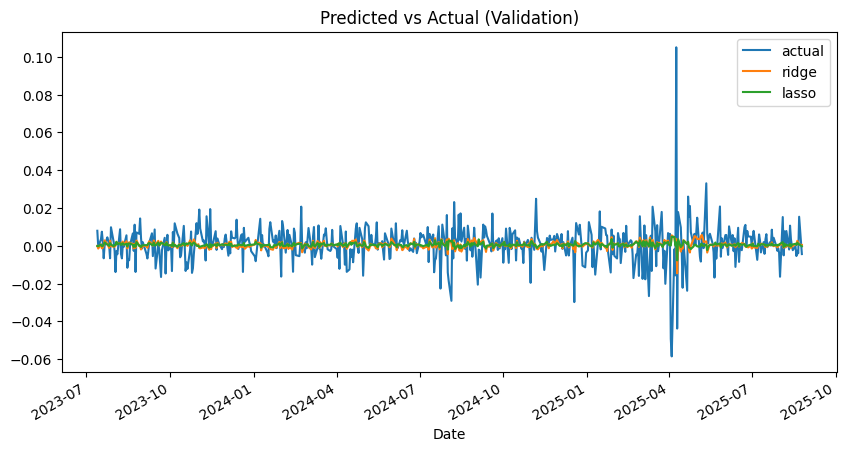

In [9]:
pd.DataFrame({"actual": y_test, "ridge": pred_ridge, "lasso": pred_lasso}).plot()
plt.title("Predicted vs Actual (Validation)"); plt.show()


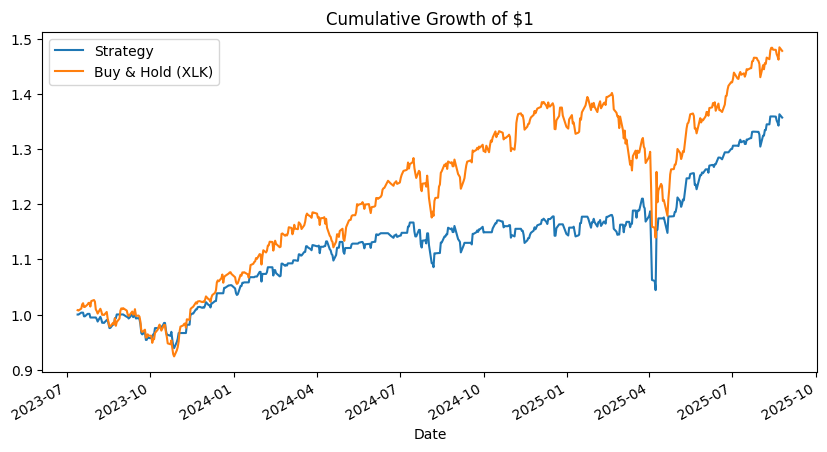

Strategy CAGR-ish: 15.59% | Buy&Hold: 20.36%


In [10]:
pred = pd.Series(pred_ridge, index=y_test.index, name="pred")
signal = (pred > 0).astype(int)          # 1=long, 0=flat
strat_ret = signal * y_test

cum_strat = (1 + strat_ret).cumprod()
cum_buyhold = (1 + y_test).cumprod()

ax = cum_strat.plot(label="Strategy")
cum_buyhold.plot(ax=ax, label="Buy & Hold (XLK)")
plt.legend(); plt.title("Cumulative Growth of $1"); plt.show()

strategy_cagr = cum_strat.iloc[-1]**(252/len(cum_strat)) - 1
buyhold_cagr  = cum_buyhold.iloc[-1]**(252/len(cum_buyhold)) - 1
print(f"Strategy CAGR-ish: {strategy_cagr:.2%} | Buy&Hold: {buyhold_cagr:.2%}")


In [11]:
dump(ridge, "../reports/ridge_model.joblib")
X_test.to_csv("../data/test_features.csv")
y_test.to_csv("../data/test_target.csv")


In [12]:
tickers = ["XLK", "SPY", "^VIX", "QQQ", "SOXX"]
px = yf.download(tickers, start="2015-01-01", auto_adjust=True)["Close"].dropna()
px.columns = ["XLK","SPY","VIX","QQQ","SOXX"]

ret = px.pct_change().dropna().rename(columns={
    "XLK":"ret_xlk", "SPY":"ret_spy", "VIX":"ret_vix", "QQQ":"ret_qqq", "SOXX":"ret_soxx"
})

feat = pd.DataFrame(index=ret.index)
for col in ["ret_xlk","ret_spy","ret_vix","ret_qqq","ret_soxx"]:
    feat[col] = ret[col]
feat["mom_5"]  = ret["ret_xlk"].rolling(5).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat = feat.dropna()

X = feat[["ret_spy","ret_vix","ret_qqq","ret_soxx","mom_5","vol_10"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]



[*********************100%***********************]  5 of 5 completed
